In [17]:
import os, sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE

from IPython.display import display, Markdown

In [2]:
df = pd.read_csv("../final_data_featured_filtered.csv")
df.tail()

,A,B,D2,E,G,policy_label
31115,0.007734,0.549692,0.500000,0.773126,0.999582,1.0
31116,0.078986,0.553054,0.576117,0.942918,0.999487,1.0
31117,0.009356,0.544649,0.500000,0.979812,0.957214,1.0
31118,0.012299,0.536573,0.500000,0.796173,0.999015,1.0
31119,0.100145,0.530914,0.500000,0.984082,0.999614,1.0


In [3]:
X = df[["A","B","D2","E","G"]]
y = df.policy_label

In [4]:
# stratified train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# calculate class_weight
# classes = np.unique(y_train)
# class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
# class_weight_dict = dict(zip(classes, class_weights))
# print("Class weights:", class_weight_dict)

In [5]:
#oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42) 
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [6]:
# MLP model
model = Sequential([
    Input(shape=(5,)),
    
    Dense(64),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(32),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=
              [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
                ])

In [7]:
early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,             
    restore_best_weights=True,
    min_delta=0.00001
)

In [8]:
# training
history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    #class_weight=class_weight_dict,
    verbose=1,
    #callbacks=[early_stop]
)

Epoch 1/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4967 - loss: 0.7795 - precision: 0.4950 - recall: 0.3265 - val_accuracy: 0.6629 - val_loss: 0.6552 - val_precision: 0.9031 - val_recall: 0.6903
Epoch 2/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.5607 - loss: 0.7044 - precision: 0.5708 - recall: 0.4893 - val_accuracy: 0.6843 - val_loss: 0.6083 - val_precision: 0.9187 - val_recall: 0.7028
Epoch 3/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.5957 - loss: 0.6748 - precision: 0.5998 - recall: 0.5748 - val_accuracy: 0.7150 - val_loss: 0.5766 - val_precision: 0.9244 - val_recall: 0.7357
Epoch 4/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.6087 - loss: 0.6648 - precision: 0.6103 - recall: 0.6013 - val_accuracy: 0.7203 - val_loss: 0.5669 - val_precision: 0.9281 - val_recall: 0.7388
Epoch 5/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.6166 - loss: 0.6613 - precision: 0.6176 - recall: 0.6119 - val_accuracy: 0.7298 -

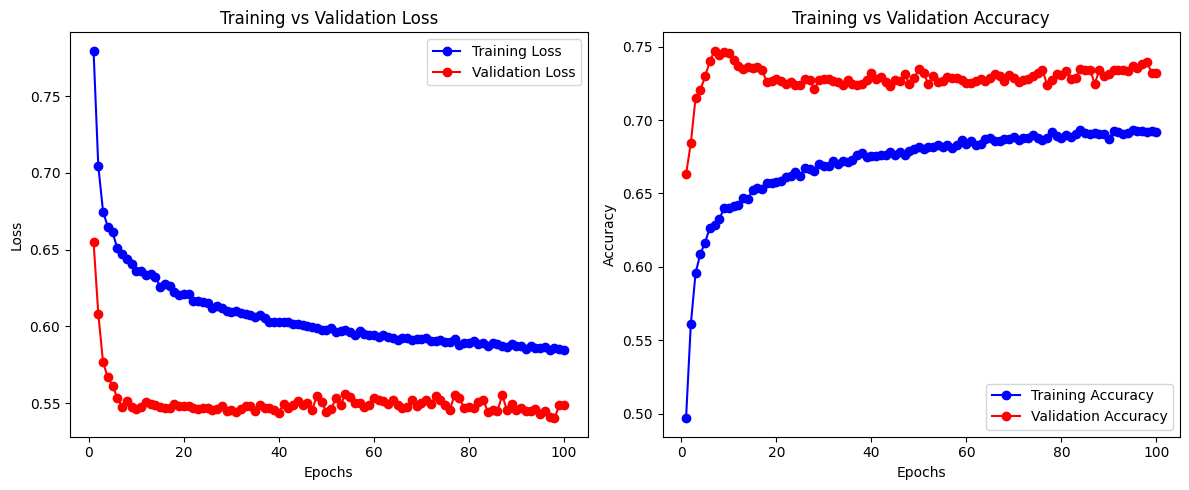

In [9]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# loss Graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
y_val_pred_probs = model.predict(X_val)
y_val_pred = (y_val_pred_probs > 0.5).astype(int)

display(Markdown("### ML Model: Multi-Layer Perceptron"))
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Model Accuracy: {accuracy:.2f}")

precesion = precision_score(y_val, y_val_pred)
print(f"Model Precision: {precesion:.2f}")

recall = recall_score(y_val, y_val_pred)
print(f"Model Recall: {recall:.2f}")

f1 = f1_score(y_val, y_val_pred)
print(f"Model F1-Score: {f1:.2f}")

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


### ML Model: Multi-Layer Perceptron

Model Accuracy: 0.73
Model Precision: 0.95
Model Recall: 0.73
Model F1-Score: 0.83
